## Kaggle European Soccer Database Analysis
### 2. Predict Goal Occurrence with Poisson Model

The database is downloaded here: [Kaggle European Soccer Database](https://www.kaggle.com/hugomathien/soccer).
### Highlights
* **Home team advantage is confirmed. In both reality and prediction, home team win 46%, draw 25%, lose 29%.**
* **Average number of goals in a match is 2.71, with 1.54 for home team, and 1.16 for away team.**
* **The most popular match score is 1:1, with a percentage of 12%.**
* **Poisson model can be used to predict distributions of number of goals,  match results, and match scores.**

### Table of Contents
#### 1. [League Comparison: Number of Goals](#1)
#### 2. [Top Matches and Teams](#2)
#### 3. [Poisson Distribution](#3)
* 3.1 [Predict Goal Occurrence](#3.1)
* 3.2 [Predict Match Results (home team win/draw/lose percentage)](#3.2)
* 3.3 [Predict Match Scores](#3.3)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3, pickle, os
from scipy.stats import poisson  # poisson distribution
from scipy.stats import skellam  # skellam distribution
from matplotlib.ticker import FormatStrFormatter

sns.set_style('whitegrid')
sns.set_context('poster')

In [2]:
# Establish connection to database
# database file name
db_filename = 'database.sqlite'

# database file directory
db_filedir = os.path.join(os.path.pardir, os.path.pardir, 'data_source', 'kaggle', db_filename)

con=sqlite3.connect(db_filedir)
cursor=con.execute("select name from sqlite_master where type='table'")

print('Following Tables are found in the database:')
for i in cursor.fetchall():
    print('{}'.format(i[0]))

Following Tables are found in the database:
sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


In [3]:
# read player table
player = pd.read_sql_query('select * from Player', con)
# read match table
match = pd.read_sql_query('select * from Match', con)
# read league table
league = pd.read_sql_query('select * from League', con)
# read country table
country = pd.read_sql_query('select * from Country', con)
# read team table
team = pd.read_sql_query('select * from Team', con)

In this section, let's explore match table.

In [4]:
print('The match table has {} columns. The columns are: \n{}\n'.format(match.shape[1], match.columns.values))
print(match.info())
print('\nThe first 2 rows of match table:')
match.head(2)

The match table has 115 columns. The columns are: 
['id' 'country_id' 'league_id' 'season' 'stage' 'date' 'match_api_id'
 'home_team_api_id' 'away_team_api_id' 'home_team_goal' 'away_team_goal'
 'home_player_X1' 'home_player_X2' 'home_player_X3' 'home_player_X4'
 'home_player_X5' 'home_player_X6' 'home_player_X7' 'home_player_X8'
 'home_player_X9' 'home_player_X10' 'home_player_X11' 'away_player_X1'
 'away_player_X2' 'away_player_X3' 'away_player_X4' 'away_player_X5'
 'away_player_X6' 'away_player_X7' 'away_player_X8' 'away_player_X9'
 'away_player_X10' 'away_player_X11' 'home_player_Y1' 'home_player_Y2'
 'home_player_Y3' 'home_player_Y4' 'home_player_Y5' 'home_player_Y6'
 'home_player_Y7' 'home_player_Y8' 'home_player_Y9' 'home_player_Y10'
 'home_player_Y11' 'away_player_Y1' 'away_player_Y2' 'away_player_Y3'
 'away_player_Y4' 'away_player_Y5' 'away_player_Y6' 'away_player_Y7'
 'away_player_Y8' 'away_player_Y9' 'away_player_Y10' 'away_player_Y11'
 'home_player_1' 'home_player_2' 'home_

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


#### Reconstruct match table with readable information

In [5]:
# add country name 
country.columns = ['country_id', 'country']
match = pd.merge(match, country, on='country_id', how='left')

# add league name
league.columns = ['league_id', 'country_id', 'league']
match = pd.merge(match, league[['league_id', 'league']], on='league_id', how='left')

# add home team name
home_team = team
home_team.columns = ['id', 'home_team_api_id', 'home_team_fifa_api_id', 'home_team', 'home_team_short_name']
match = pd.merge(match, home_team[['home_team_api_id', 'home_team']], on='home_team_api_id', how='left')

# add away team name
away_team = team
away_team.columns = ['id', 'away_team_api_id', 'away_team_fifa_api_id', 'away_team', 'away_team_short_name']
match = pd.merge(match, away_team[['away_team_api_id', 'away_team']], on='away_team_api_id', how='left')

match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,country,league,home_team,away_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1.50,3.75,5.50,1.44,3.75,6.50,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,4.50,3.50,1.65,4.75,3.30,1.67,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège


Select features for data analysis in this section.

Create goal difference and total goal columns.

In [6]:
# select demand columns
selected_columns=['country', 'league', 'season', 'stage', 'date', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal']
match_goal = match[selected_columns]

for col in ['home_team_goal', 'away_team_goal']:
    match_goal = match_goal[match_goal[col].notnull()]

# create goal difference column
match_goal['home_team_gd']=match_goal['home_team_goal']-match_goal['away_team_goal']

# create total goal column
match_goal['total_goal']=match_goal['home_team_goal'] + match_goal['away_team_goal']

In [7]:
match_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 11 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
stage             25979 non-null int64
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
home_team_gd      25979 non-null int64
total_goal        25979 non-null int64
dtypes: int64(5), object(6)
memory usage: 2.4+ MB


#### <a id='1'></a>1. League Comparison: Number of Goals

#### Home team

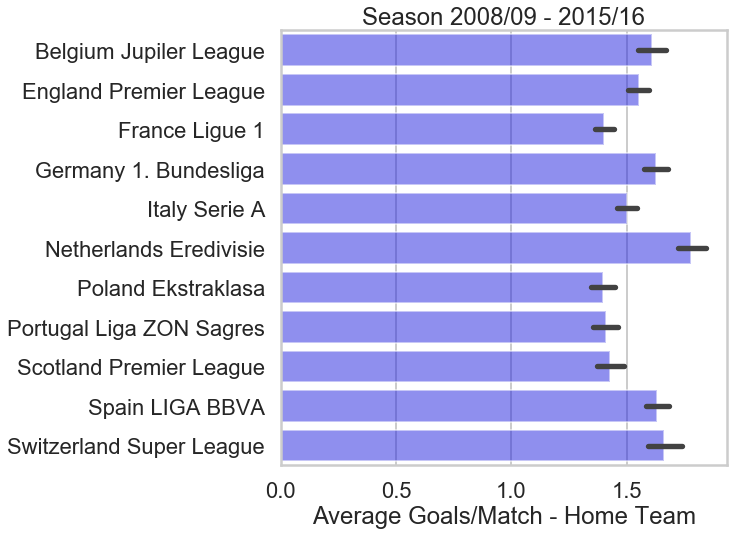

In [8]:
plt.figure(figsize=(8,8))
sns.barplot(y="league", x="home_team_goal", color='b',alpha=0.5,data=match_goal)
plt.ylabel('')
plt.xlabel('Average Goals/Match - Home Team')
plt.title('Season 2008/09 - 2015/16')

Netherlands Eredivisie has most home team score rate (1.78 goal/match). Poland Ekstraklasa has least home team score rates (1.39 goal/match).

#### Away team 

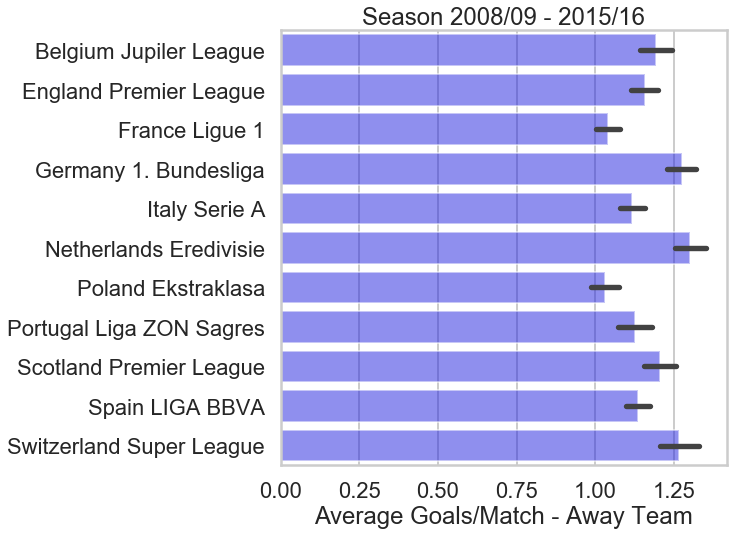

In [9]:
plt.figure(figsize=(8,8))
sns.barplot(y="league", x="away_team_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Average Goals/Match - Away Team')
plt.title('Season 2008/09 - 2015/16')

Netherlands Eredivisie has most away team score rate (1.30 goal/match). Poland Ekstraklasa has least away team score rate (1.03 goal/match).

#### Total Goals

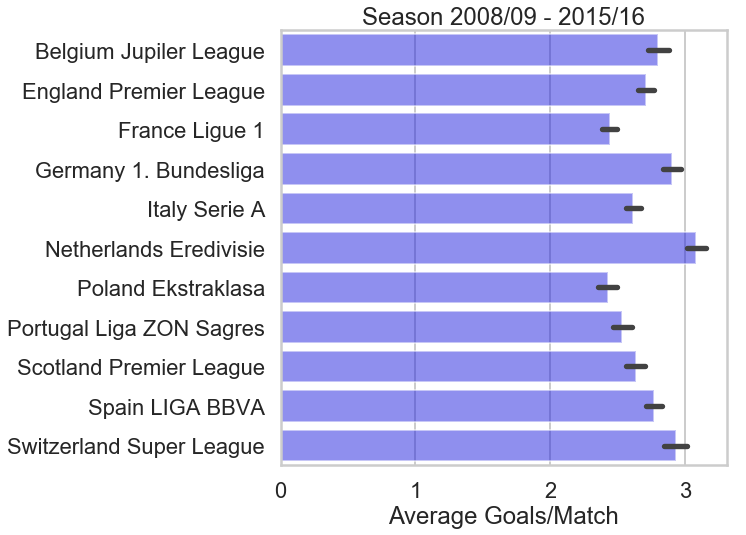

In [10]:
plt.figure(figsize=(8,8))
sns.barplot(y="league", x="total_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Average Goals/Match')
plt.title('Season 2008/09 - 2015/16')

Netherlands Eredivisie scores most in each match on average (3.08 goal/match). Poland Ekstraklasa scores least (2.43 goal/match). 

#### Goal Difference

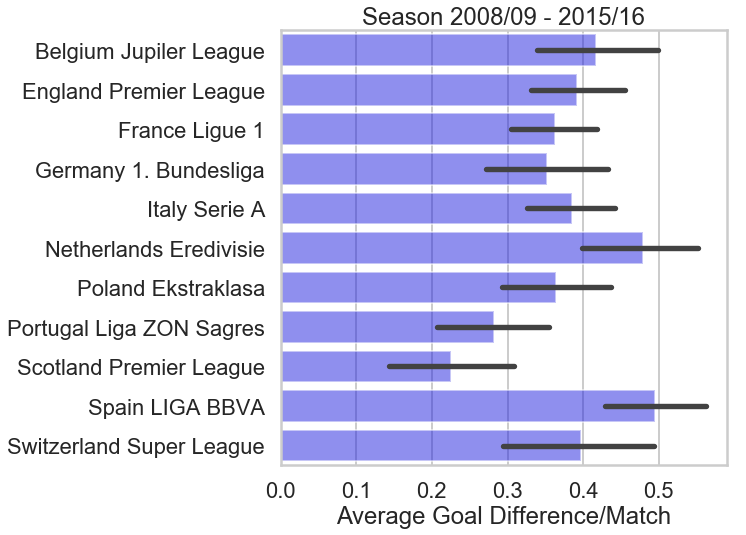

In [11]:
plt.figure(figsize=(8,8))
sns.barplot(y="league", x="home_team_gd", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Average Goal Difference/Match')
plt.title('Season 2008/09 - 2015/16')

* Home team scores more than away team in all 11 leagues on average. Home team advantage confirmed.
* Spain LIGA BBVA's home team has most home team advantage (with goal difference of 0.50).
* Scotland Premier League's home team has least home team advantage (with goal difference of 0.22).

#### <a id='2'></a>2. Top Matches and Teams
#### Top 10 matches: home team scores most

In [12]:
n_top = 10
match_goal.sort_values('home_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
22587,Spain,Spain LIGA BBVA,2010/2011,38,2011-05-21 00:00:00,Real Madrid CF,UD Almería,8,1,7,9
21337,Scotland,Scotland Premier League,2015/2016,17,2016-01-19 00:00:00,Celtic,Hamilton Academical FC,8,1,7,9


#### Top 10 matches: away team scores most

In [13]:
n_top = 10
match_goal.sort_values('away_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
24736,Switzerland,Switzerland Super League,2008/2009,9,2008-09-14 00:00:00,FC Vaduz,FC Zürich,1,7,-6,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
24765,Switzerland,Switzerland Super League,2009/2010,14,2009-10-29 00:00:00,AC Bellinzona,BSC Young Boys,1,7,-6,8


#### Top 10 matches: home team wins with most goal difference

In [14]:
n_top = 10
match_goal.sort_values('home_team_gd',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
22984,Spain,Spain LIGA BBVA,2011/2012,4,2011-09-17 00:00:00,FC Barcelona,CA Osasuna,8,0,8,8
9761,Germany,Germany 1. Bundesliga,2014/2015,21,2015-02-14 00:00:00,FC Bayern Munich,Hamburger SV,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2420,England,England Premier League,2009/2010,38,2010-05-09 00:00:00,Chelsea,Wigan Athletic,8,0,8,8
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8


#### Top 10 matches: away team wins with most goal difference

In [15]:
n_top = 10
match_goal.sort_values('home_team_gd').head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
22949,Spain,Spain LIGA BBVA,2011/2012,36,2012-04-29 00:00:00,Rayo Vallecano,FC Barcelona,0,7,-7,7
9395,Germany,Germany 1. Bundesliga,2013/2014,15,2013-12-07 00:00:00,SV Werder Bremen,FC Bayern Munich,0,7,-7,7
12463,Italy,Italy Serie A,2013/2014,4,2013-09-22 00:00:00,Sassuolo,Inter,0,7,-7,7
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9


#### Top 10 matches: most total goal

In [16]:
n_top = 10
match_goal.sort_values('total_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
3092,England,England Premier League,2011/2012,3,2011-08-28 00:00:00,Manchester United,Arsenal,8,2,6,10
3368,England,England Premier League,2012/2013,20,2012-12-29 00:00:00,Arsenal,Newcastle United,7,3,4,10
23443,Spain,Spain LIGA BBVA,2013/2014,11,2013-10-30 00:00:00,Real Madrid CF,Sevilla FC,7,3,4,10
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
24113,Spain,Spain LIGA BBVA,2014/2015,38,2015-05-23 00:00:00,Real Madrid CF,Getafe CF,7,3,4,10
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10


#### Matches with both teams score more than 4 goals

In [17]:
match_goal[(match_goal['home_team_goal']>4)&(match_goal['away_team_goal']>4)]

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
3565,England,England Premier League,2012/2013,38,2013-05-19 00:00:00,West Bromwich Albion,Manchester United,5,5,0,10
5191,France,France Ligue 1,2009/2010,13,2009-11-08 00:00:00,Olympique Lyonnais,Olympique de Marseille,5,5,0,10
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12


#### Top 10 home teams with best attack

In [18]:
# Average home team goal stats
home_avg_goal = match_goal[['home_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('home_team',as_index=False).mean()

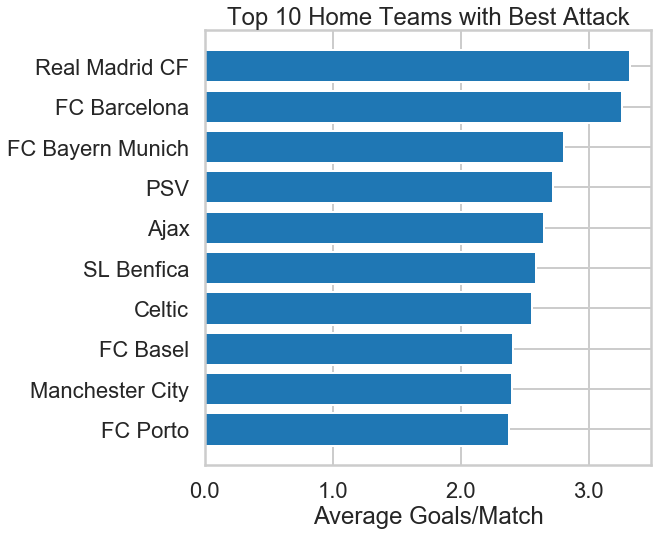

In [19]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_attack = home_avg_goal.sort_values('home_team_goal',ascending=False)[['home_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(np.arange(n_top), top_home_team_attack['home_team_goal'].values, align = 'center')
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_attack['home_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Average Goals/Match')
ax.set_title('Top {} Home Teams with Best Attack'.format(n_top))

#### Top 10 home teams with best defence

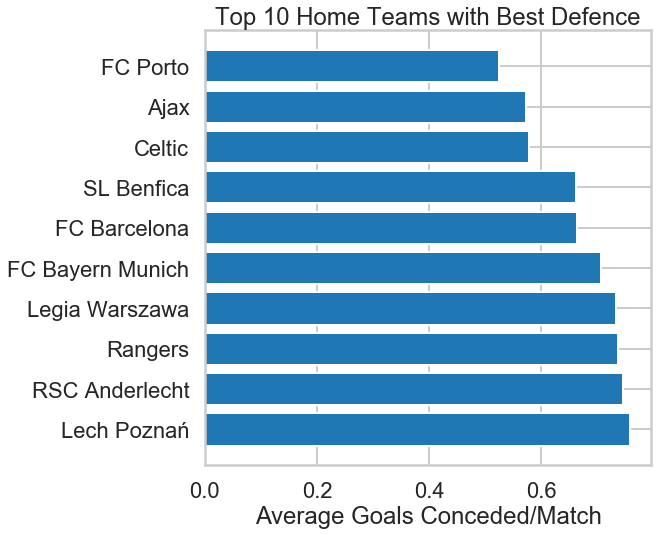

In [20]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_defence = home_avg_goal.sort_values('away_team_goal')[['home_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(np.arange(n_top), top_home_team_defence['away_team_goal'].values, align = 'center')
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_defence['home_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Average Goals Conceded/Match')
ax.set_title('Top {} Home Teams with Best Defence'.format(n_top))

#### Top 10 away teams with best attack

In [21]:
# Average away team stats
away_avg_goal = match_goal[['away_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('away_team',as_index=False).mean()

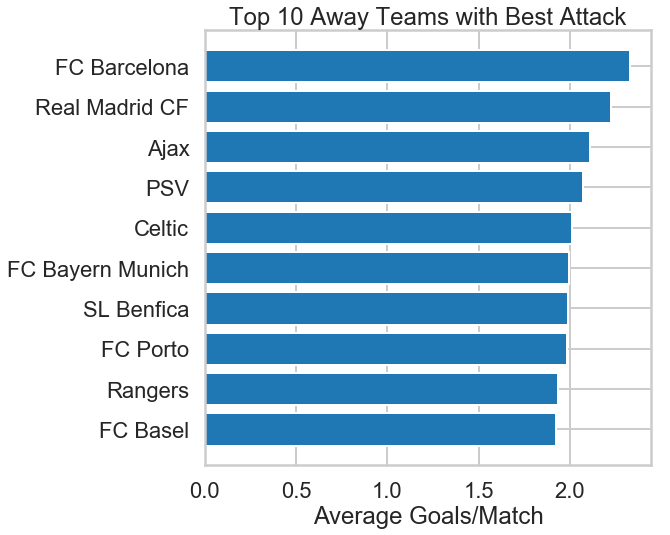

In [22]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_attack = away_avg_goal.sort_values('away_team_goal',ascending=False)[['away_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(np.arange(n_top), top_away_team_attack['away_team_goal'].values, align = 'center')
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_attack['away_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Average Goals/Match')
ax.set_title('Top {} Away Teams with Best Attack'.format(n_top))

#### Top 10 away teams with best defence

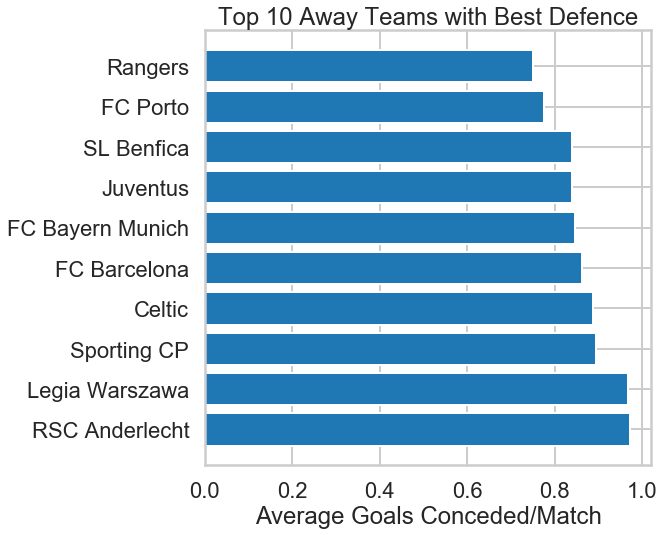

In [23]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_defence = away_avg_goal.sort_values('home_team_goal')[['away_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(np.arange(n_top), top_away_team_defence['home_team_goal'].values, align = 'center')
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_defence['away_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Average Goals Conceded/Match')
ax.set_title('Top {} Away Teams with Best Defence'.format(n_top))

#### <a id='3'></a>3. Poisson Distribution
$$P(X = k) = \frac{\lambda^ke^{-\lambda}}{k!}, k = 0,1,2,...$$
#### <a id='3.1'></a>3.1 Predict Goal Occurrence
Goal occurrence follows Poisson distribution.

#### Home team

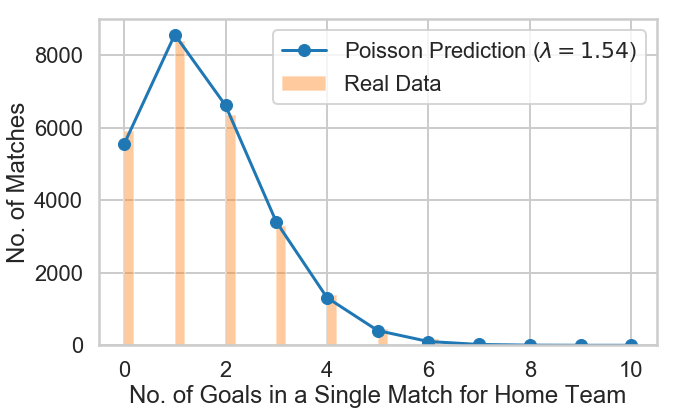

In [24]:
# Estimate lambda for home team goal
lambda_home = match_goal['home_team_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_home)*match_goal.shape[0], '-o', label="Poisson Prediction ($\lambda={:.2f}$)".format(lambda_home))
sns.distplot(match_goal['home_team_goal'],kde=False, label='Real Data')
plt.xlabel('No. of Goals in a Single Match for Home Team')
plt.ylabel('No. of Matches')
plt.legend()

#### Away team

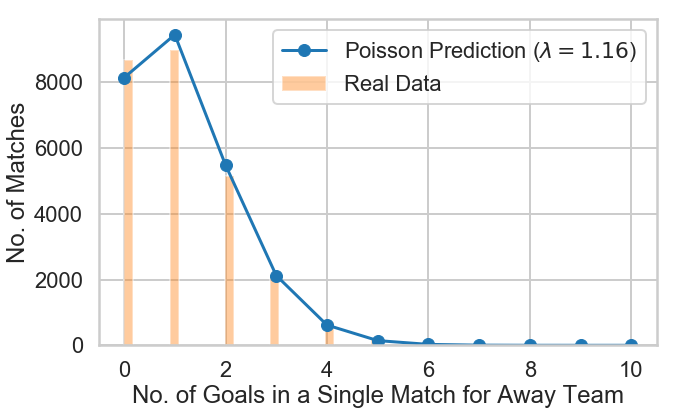

In [25]:
# Estimate lambda for home team goal
lambda_away=match_goal['away_team_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_away)*match_goal.shape[0], '-o', label="Poisson Prediction ($\lambda={:.2f}$)".format(lambda_away))
sns.distplot(match_goal['away_team_goal'],kde=False, label='Real Data')
plt.xlabel('No. of Goals in a Single Match for Away Team')
plt.ylabel('No. of Matches')
plt.legend()

Conclusion: goal occurrence follows Poisson distribution.

#### Total Goal
Total goal also follows Poisson distribution. home team goal ~ $\lambda_{home}$, away team goal ~ $\lambda_{away}$, so total goal ~ $\lambda_{home}+\lambda_{away}$[[1]](https://math.stackexchange.com/questions/221078/poisson-distribution-of-sum-of-two-random-independent-variables-x-y).

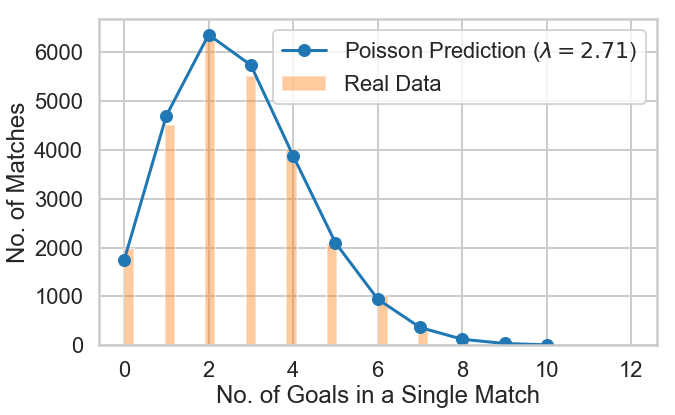

In [26]:
# Estimate lambda for total goal
lambda_total=match_goal['total_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_total)*match_goal.shape[0], '-o', label="Poisson Prediction ($\lambda={:.2f}$)".format(lambda_total))
sns.distplot(match_goal['total_goal'],kde=False, label='Real Data')
plt.xlabel('No. of Goals in a Single Match')
plt.ylabel('No. of Matches')
plt.legend()
#plt.savefig('poisson_match_goal.jpg', dpi=400)

#### Goal Difference

Goal difference follows Skellam distribution [[2]](https://en.wikipedia.org/wiki/Skellam_distribution) [[3]](https://stats.stackexchange.com/questions/47749/how-to-calculate-cumulative-poisson-probabilities-without-adding-each-one-if-no).

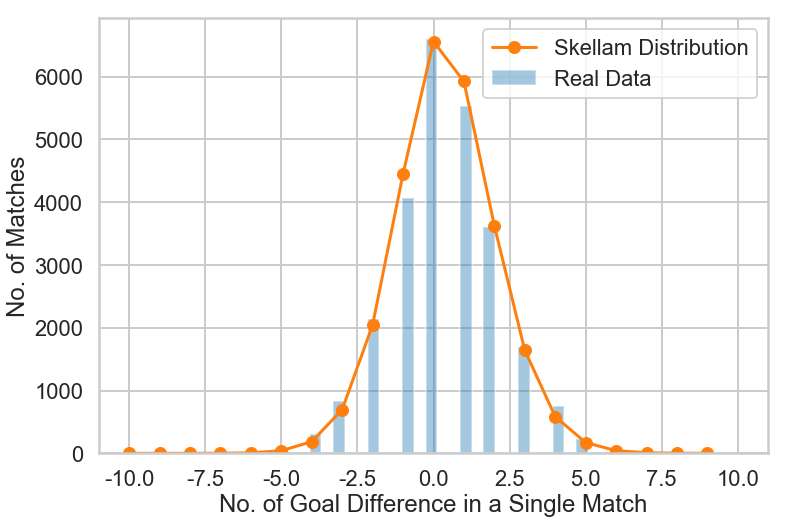

In [27]:
# define goal difference range for plot
gd_range = np.arange(20) - 10   # -10 to 9

plt.figure(figsize=(12,8))
sns.distplot(match_goal['home_team_gd'],kde=False, label='Real Data')
plt.plot(gd_range, skellam.pmf(gd_range, lambda_home, lambda_away)*match_goal.shape[0], '-o', label="Skellam Distribution")
plt.xlabel('No. of Goal Difference in a Single Match')
plt.ylabel('No. of Matches')
plt.legend()

#### <a id='3.2'></a>3.2 Predict Match Result (Home Team Win/Draw/Lose Percentage)

In [28]:
# Encode match result
# home team win:  0
# home team draw: 1
# home team lose: 2
match_goal['result'] = np.where(match_goal['home_team_gd'] > 0, 0, np.where(match_goal['home_team_gd'] < 0, 2, 1))

Use Poisson Distribution to add up probability of home team win/draw/lose.

In [29]:
# Use Possion Distribution to predict match result percentage
p_win, p_draw, p_lose = 0, 0, 0

# Maxmium number of goals for a team per match
n_max = 20

# Loop over all possibility of home team goal
for i in np.arange(n_max):
    # Loop over all possibility of away team goal
    for j in np.arange(n_max):
        # home team win
        if i > j:
            p_win = p_win+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # draw
        elif i == j:
            p_draw = p_draw+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # home team lose
        else:
            p_lose = p_lose+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]

# home team win ratio
print('Home Team Win Percentage:       {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('Predicted Home Win Probability: {:.2f}%\n'.format(p_win*100))

# draw ratio
print('Home Team Draw Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('Predicted Draw Probability:     {:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('Home Team Lose Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('Predicted Home Lose Probability:{:.2f}%\n'.format(p_lose*100))

Home Team Win Percentage:       45.87%
Predicted Home Win Probability: 46.16%

Home Team Draw Percentage:      25.39%
Predicted Draw Probability:     25.24%

Home Team Lose Percentage:      28.74%
Predicted Home Lose Probability:28.60%



Alternatively, using Skellam Distribution should give exactly the same result.

In [30]:
# Use Skellam Distribution to predict match result percentage

# n_max: range of goal difference. For example, if n_max = 3, the calcution will add up p(1), p(2) and p(3) for home team win,
# and will add up p(-1), (p-2) and p(-3) for home team lose
n_max = 20

p_win = np.sum(skellam.pmf(np.arange(n_max)+1, lambda_home, lambda_away))
p_draw = np.sum(skellam.pmf(0, lambda_home, lambda_away))
p_lose = np.sum(skellam.pmf(np.arange(n_max)-n_max, lambda_home, lambda_away))

# home team win ratio
print('Home Team Win Percentage:       {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('Predicted Home Win Probability: {:.2f}%\n'.format(p_win*100))

# draw ratio
print('Home Team Draw Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('Predicted Draw Probability:     {:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('Home Team Lose Percentage:      {:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('Predicted Home Lose Probability:{:.2f}%\n'.format(p_lose*100))

Home Team Win Percentage:       45.87%
Predicted Home Win Probability: 46.16%

Home Team Draw Percentage:      25.39%
Predicted Draw Probability:     25.24%

Home Team Lose Percentage:      28.74%
Predicted Home Lose Probability:28.60%



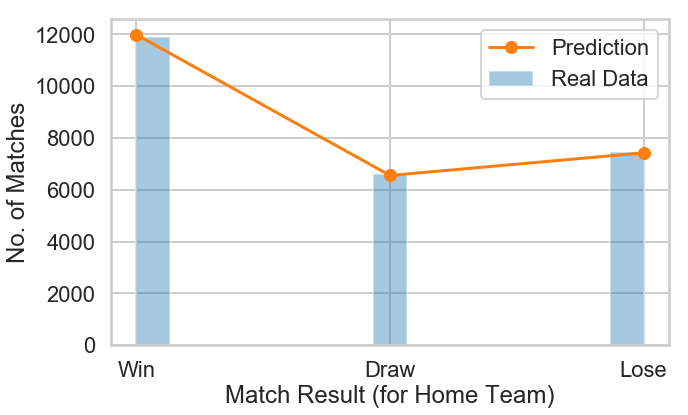

In [31]:
# Plot number of 3 match results against predicted number of 3 match results (home team win/draw/lose)
plt.figure(figsize=(10,6))
ax = sns.distplot(match_goal['result'],kde=False, label='Real Data')
plt.plot(np.arange(3), match_goal.shape[0]*np.array([p_win, p_draw, p_lose]), '-o', label="Prediction")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Win', 'Draw', 'Lose'])
plt.xlabel('Match Result (for Home Team)')
plt.ylabel('No. of Matches')
plt.legend()

The numbers of predicted 3 match results matches with actual number of 3 match results very well.

#### <a id='3.3'></a>3.3 Predict Match Scores

Use Poisson Distribution to predict the probability of a specific match score.

In [32]:
# max goal for each team
max_goal = 4

# The row index is home team score, and the column index is away team score,
# the value is the probability for this match score
# define a matrix to store prediced probability for match scores
match_score_pred = np.zeros((max_goal+1,max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        # Predict with poisson distribution
        match_score_pred[i,j] = poisson.pmf(np.arange(max_goal+1), lambda_home)[i]*poisson.pmf(np.arange(max_goal+1), lambda_away)[j]

# define a matrix to store actual percentage for match scores
match_score = np.zeros((max_goal+1, max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        match_score[i,j] = match_goal[(match_goal['home_team_goal'] == i)&(match_goal['away_team_goal'] == j)].shape[0]/match_goal.shape[0]

In [33]:
print('MATCH SCORE PREDICTION')
print('Match Score | Acutal Percentage | Predicted Probability')
for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        print('{:5.0f}:{}{:15.2f}%{:20.2f}%'.format(i, j, match_score[i,j]*100, match_score_pred[i, j]*100))

MATCH SCORE PREDICTION
Match Score | Acutal Percentage | Predicted Probability
    0:0           7.61%                6.68%
    0:1           7.17%                7.76%
    0:2           4.64%                4.50%
    0:3           2.06%                1.74%
    0:4           0.85%                0.51%
    1:0          10.17%               10.32%
    1:1          11.60%               11.98%
    1:2           6.39%                6.96%
    1:3           2.85%                2.69%
    1:4           0.95%                0.78%
    2:0           8.21%                7.97%
    2:1           8.39%                9.26%
    2:2           5.04%                5.37%
    2:3           1.88%                2.08%
    2:4           0.64%                0.60%
    3:0           4.34%                4.10%
    3:1           4.64%                4.77%
    3:2           2.36%                2.77%
    3:3           1.02%                1.07%
    3:4           0.19%                0.31%
    4:0           2.0

The predicted probabilities of match scores match with real ratios quite well.

#### Top 10 Popular match scores

In [34]:
# Top 10 popular match scores
n_top = 10

print('Top {} Match Scores in Prediction'.format(n_top))
print('Match Score | Probability')

for i in np.arange(n_top):
    home_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][1]
    print('{:5.0f}:{}{:17.2f}%'.format(home_index, away_index, np.partition(match_score_pred.flatten(), -i-1)[-i-1]*100))

print('\nTop {} Match Scores in Reality'.format(n_top))
print('Match Score | Percentage')
for i in np.arange(10):
    home_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][1]
    print('{:5.0f}:{}{:17.2f}%'.format(home_index, away_index, np.partition(match_score.flatten(), -i-1)[-i-1]*100))

Top 10 Match Scores in Prediction
Match Score | Probability
    1:1            11.98%
    1:0            10.32%
    2:1             9.26%
    2:0             7.97%
    0:1             7.76%
    1:2             6.96%
    0:0             6.68%
    2:2             5.37%
    3:1             4.77%
    0:2             4.50%

Top 10 Match Scores in Reality
Match Score | Percentage
    1:1            11.60%
    1:0            10.17%
    2:1             8.39%
    2:0             8.21%
    0:0             7.61%
    0:1             7.17%
    1:2             6.39%
    2:2             5.04%
    3:1             4.64%
    0:2             4.64%
